/usr/local/Cellar/micromamba/2.3.0/envs/noise/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator HistGradientBoostingRegressor from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/Cellar/micromamba/2.3.0/envs/noise/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator _BinMapper from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/Cellar/micromamba/2.3.0/envs/noise/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to

Using local elevation data
CPU times: user 5.29 s, sys: 10.2 s, total: 15.5 s
Wall time: 39.9 s


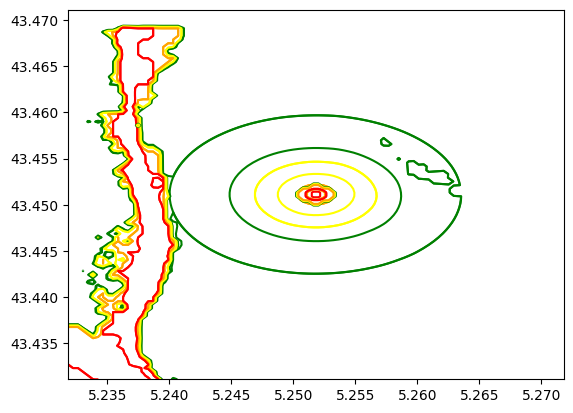

In [4]:
%%time
from windwhisper import WindTurbines, NoisePropagation, NoiseAnalysis
import xarray as xr

# we can preload the wind speed data, otherwise, the tool will do it every time
filepath_wind_speed = "fixtures/era5_mean_2013-2022_month_by_hour.nc"
filepath_correction = "fixtures/ratio_gwa2_era5.nc"

def wind_speed_data():

    wind_speed = xr.open_dataset(filepath_wind_speed).to_array().mean(dim="month")
    correction = xr.open_dataset(filepath_correction).to_array()
    correction = correction.sel(variable='ratio_gwa2_era5_mean_WS').interp(latitude=wind_speed.latitude, longitude=wind_speed.longitude, method="linear")
    return wind_speed * correction

wind_speed_data = wind_speed_data()

wind_turbines = {
    'Turbine 0':
     {
        'diameter': 70.0,
        'hub height': 85.0,
        'position': (43.45111343125036, 5.2518247370645215),
        'power': 2500.0
     },
}



wt = WindTurbines(
    wind_turbines=wind_turbines,
    wind_speed_data=wind_speed_data,
    #retrain_model=True
)

# note: make ensure latitude and longitude coordinates are sorted in ascending order
elevation_data = xr.open_dataset("fixtures/Copernicus_DSM_90m_COG.nc")

noise_prop = NoisePropagation(
    wind_turbines=wt.wind_turbines,
    humidity=70,
    temperature=20,
    elevation_data=elevation_data,
)

noise_analysis = NoiseAnalysis(
    noise_propagation=noise_prop,
    wind_turbines=wt.wind_turbines,
)

contours = noise_analysis.get_geojson_contours()


In [15]:
noise_analysis.merged_map["combined"].to_dataframe().to_excel("example.xlsx")

In [14]:
%pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.


In [3]:
type(elevation_data)

xarray.core.dataset.Dataset

In [4]:
elevation_data = elevation_data.sortby("latitude")

In [6]:
elevation_data.to_netcdf("/Users/romain/Github/windwhisper/dev/fixtures/Copernicus_DSM_90m_COG_sorted.nc")

In [2]:
elevation_data.coords

Coordinates:
  * latitude   (latitude) float64 355kB 72.0 72.0 72.0 72.0 ... 35.0 35.0 35.0
  * longitude  (longitude) float64 378kB -11.0 -11.0 -11.0 ... 45.0 45.0 45.0

Generate an HTML map of the noise levels

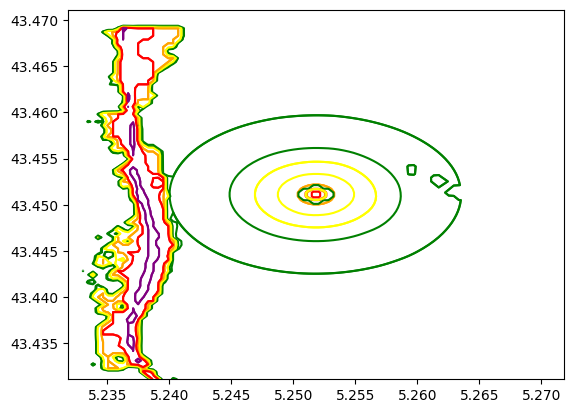

In [4]:
noise_analysis.generate_map(
    filepath="my_noise_map.html"
)

Fetch geoJson contour objects for ambient noise, noise from wind turbines, ambient + wind turbine noise, net wind turbine noise contribution, and noise levels above EU guidelines.

({"features": [{"geometry": {"coordinates": [[5.239395, 43.431113], [5.239097, 43.43139], [5.238978, 43.431517], [5.238919, 43.431922], [5.238693, 43.432116], [5.238289, 43.432212], [5.238151, 43.432326], [5.238289, 43.432458], [5.238536, 43.43273], [5.238468, 43.433134], [5.238289, 43.433299], [5.238038, 43.433538], [5.237885, 43.433688], [5.237707, 43.433942], [5.23769, 43.434346], [5.23768, 43.43475], [5.237689, 43.435154], [5.237697, 43.435558], [5.237687, 43.435962], [5.23768, 43.436366], [5.23768, 43.43677], [5.237694, 43.437174], [5.23771, 43.437578], [5.237885, 43.437773], [5.238099, 43.437982], [5.23812, 43.438386], [5.238289, 43.438579], [5.238516, 43.43879], [5.238531, 43.439194], [5.238693, 43.439341], [5.238961, 43.439598], [5.239009, 43.440002], [5.239097, 43.4401], [5.239377, 43.440406], [5.239392, 43.44081], [5.239392, 43.441214], [5.239502, 43.441538], [5.239555, 43.441618], [5.239805, 43.442023], [5.239815, 43.442427], [5.239906, 43.442606], [5.240075, 43.442831], [5.

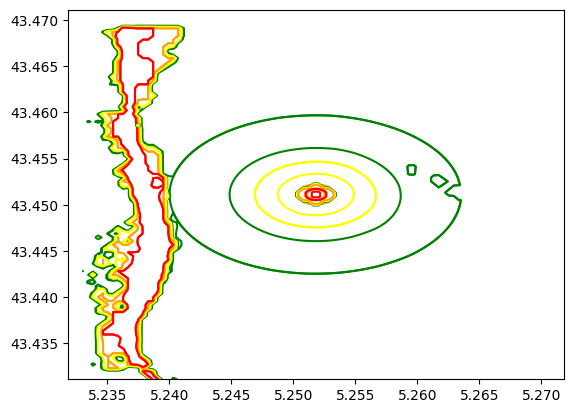

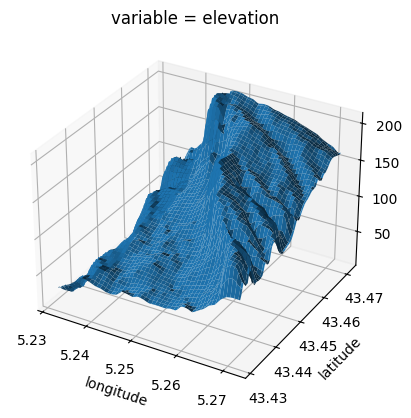

In [6]:
noise_prop.elevation_grid.plot.surface()

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def read_elevation_tif(file_path):
    # Open the .tif file using rasterio
    with rasterio.open(file_path) as dataset:
        # Read the first band (assuming a single-band DEM file)
        elevation = dataset.read(1)

        # Get metadata
        metadata = dataset.meta

        # Get georeferencing information
        crs = dataset.crs
        transform = dataset.transform

        # Print georeferencing information
        print(f"Coordinate Reference System (CRS): {crs}")
        print(f"Affine Transformation: {transform}")

        # Plot the elevation data
        plt.figure(figsize=(10, 6))
        plt.imshow(elevation, cmap='terrain', origin='upper')
        plt.colorbar(label='Elevation (m)')
        plt.title('Elevation Map')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.show()

        return elevation, metadata, crs, transform

# Example usage
elevation_data, metadata, crs, transform = read_elevation_tif(fp)


In [ ]:
import rasterio

def inspect_tif(file_path):
    with rasterio.open(file_path) as dataset:
        print("Metadata:", dataset.meta)
        print("CRS:", dataset.crs)
        print("Affine Transformation Matrix:\n", dataset.transform)
        print("Width (pixels):", dataset.width)
        print("Height (pixels):", dataset.height)
        print("Bounds:", dataset.bounds)
        print("Resolution (pixel size):", dataset.res)

# Example usage
inspect_tif(fp)


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

def read_elevation_tif(file_path):
    # Open the .tif file using rasterio
    with rasterio.open(file_path) as dataset:
        # Read the first band (assuming a single-band DEM file)
        elevation = dataset.read(1)

        # Get metadata
        metadata = dataset.meta

        # Get georeferencing information
        crs = dataset.crs
        transform = dataset.transform

        # Print georeferencing information
        print(f"Coordinate Reference System (CRS): {crs}")
        print(f"Affine Transformation: {transform}")

        # Compute longitude and latitude coordinates
        width = dataset.width
        height = dataset.height
        lon_min, lat_max = transform * (0, 0)
        lon_max, lat_min = transform * (width, height)

        lons = np.linspace(lon_min, lon_max, width)
        lats = np.linspace(lat_max, lat_min, height)

        # Convert to Xarray Dataset
        elevation_da = xr.DataArray(
            elevation,
            dims=("latitude", "longitude"),
            coords={"latitude": lats, "longitude": lons},
            attrs={"crs": str(crs), "units": "meters", "description": "Elevation data"},
        )

        elevation_ds = xr.Dataset({"elevation": elevation_da})

        # Plot the elevation data
        plt.figure(figsize=(10, 6))
        plt.imshow(elevation, cmap='terrain', origin='upper', extent=[lon_min, lon_max, lat_min, lat_max])
        plt.colorbar(label='Elevation (m)')
        plt.title('Elevation Map')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

        return elevation_ds

# Example usage
elevation_ds = read_elevation_tif(fp)
elevation_ds.to_netcdf("Copernicus_DSM_90m_COG.nc")

In [3]:
arr = xr.open_dataset("fixtures/Copernicus_DSM_90m_COG.nc")

In [4]:
arr.interp(latitude=43.45111343125036, longitude=5.2518247370645215)

<xarray.Dataset> Size: 24B
Dimensions:    ()
Coordinates:
    latitude   float64 8B 43.45
    longitude  float64 8B 5.252
Data variables:
    elevation  float64 8B 109.2

In [ ]:
 (, )